# Coding Application: Pricing a European Call Option

----

#### John Stachurski (August 2024)

----

In this notebook we use option pricing as an application to learn some Python
syntax.

## Introduction to Monte Carlo integration

Before discussing option pricing we'll quickly review Monte Carlo integration and why it's useful.

### Computing expectations

Suppose that we want to evaluate

$$
    \mathbb E f(X)
$$

where $X$ is a random variable or vector and $f$ is some given function.

This is easy if, say $f(x) = x$ and $X \sim N(0,1)$, because then 

$$
    \mathbb E f(X) 
    = \mathbb E X
    = 0
$$

But what if 

$$
    f(x) = \log(1 + |\sin(x)|)
$$ 

and $X$ is created as follows:

1. $\sigma$ is drawn from the exponential distribution with rate $\lambda = 2.0$
2. $\mu$ is drawn from a Beta$(a, b)$ distribution where $a=1.0$ and $b=3.0$
3. $Z$ is drawn as $\exp(Y)$ where $Y$ is $N(\mu, \sigma)$
4. $X$ is taken as the minimum of $Z$ and $2.0$

Now how would you compute $\mathbb E f(X)$?

In [1]:
for i in range(20):
    print("Solution below!")

Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!


**Solution**

To solve the problem numerically we can use Monte Carlo:

1. Generate $M$ IID draws $(X_i)$ of $X$
2. Approximate the mean $\mathbb E f(X)$ via the sample mean $(1/M) \sum_{m=1}^M f(X_m)$

This works because, as $M \to \infty$,

$$
\frac{1}{M} \sum_{m=1}^M f(X_m) \to \mathbb E f(X)
$$

Here's a function to draw one $X_i$

In [2]:
import numpy as np  

def draw_x():
    "Draw one observation of X."
    σ = np.random.exponential(scale=1/2)
    μ = np.random.beta(a=1.0, b=3.0)
    Y = μ + σ * np.random.randn()
    Z = np.exp(Y)
    return np.minimum(Z, 2.0)

Let's test it:

In [3]:
draw_x()

2.0

In [4]:
draw_x()

1.4045886655042803

In [5]:
draw_x()

0.8144090661901248

Let's draw $M = 10,000$ observations

In [6]:
M = 10_000
x_samples = np.empty(M)
for m in range(M):
    x_samples[m] = draw_x()

Now we define $f$ and compute the sample mean

In [7]:
def f(x):
    return np.log(1 + np.abs(np.sin(x)))
    
np.mean(f(x_samples))

0.6118019728802657

Of course, if we want a better approximation, we should increase $n$.

## Pricing a call option

Now we're ready to price a European call option under the assumption of risk neutrality.

### Set up

We consider a call option where

2. $n$ is the expiry date  (e.g., expires in $n$ days),
2. $K$ is the strike price and
3. $S_n$ is the price of the underlying asset after $n$ periods.

For example, consider a call option to buy stock in Amazon at strike price $K$. 

The owner has the right (but not the obligation) to buy 1 share in Amazon at
price $K$ after $n$ days.  

The payoff is therefore $\max\{S_n - K, 0\}$

The risk-neutral price is the expected payoff, discounted to current value:

$$
P = \beta^n \mathbb E \max\{ S_n - K, 0 \}
$$


Notice that this is another example of computing $\mathbb E f(X)$

In all of what follows we will use

In [8]:
n, β, K = 10, 0.99, 100

It remains only to specify the distribution of $S_n$.

### Distribution of the share price

Often the distribution of $S_n$ is not a simple distribution.

As one example, let's set 

$$s_t = \ln S_t$$

and assume that the log stock price obeys 

$$ 
\begin{aligned}
    s_{t+1} & = s_t + \mu + \exp(h_t) \, U_{t+1} \\
    h_{t+1} & = \rho \, h_t + \nu \, V_{t+1}
\end{aligned}
$$

Here $\{U_t\}$ and $\{V_t\}$ are IID and standard normal.

The current values $S_0$ and $h_0$ are given.

These initial conditions and the laws of motion above define the random variable
$S_n$.

We use the default values

In [9]:
μ, ρ, ν, S_0, h_0 = 0.0001, 0.01, 0.001, 10.0, 0.0

Let's plot 12 of these paths:

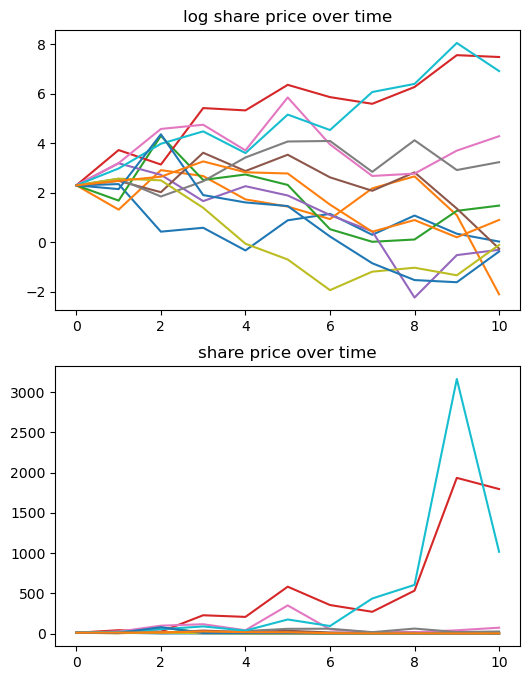

In [10]:
import matplotlib.pyplot as plt  

M = 12
fig, axes = plt.subplots(2, 1, figsize=(6, 8))
s_0 = np.log(S_0)

for m in range(M):
    s = np.empty(n+1)
    s[0], h = s_0, h_0
    for t in range(n):
        U, V = np.random.randn(2)
        s[t+1] = s[t] + μ + np.exp(h) * U
        h = ρ * h + ν * V
        
    axes[0].plot(s)
    S = np.exp(s)
    axes[1].plot(S)
    
axes[0].set_title('log share price over time')
axes[1].set_title('share price over time')
plt.show()

Here's a larger simulation, where we 

* set $M = 1000$ and
* generate $M$ draws of $s_n$

In [11]:
M, n = 1_000, 10
s_0 = np.log(S_0)
s_n = np.empty(M)

for m in range(M):
    s, h = s_0, h_0
    for t in range(n):
        U, V = np.random.randn(2)
        s = s + μ + np.exp(h) * U
        h = ρ * h + ν * V
    s_n[m] = s

Let's histogram the $M$ values of $s_n$

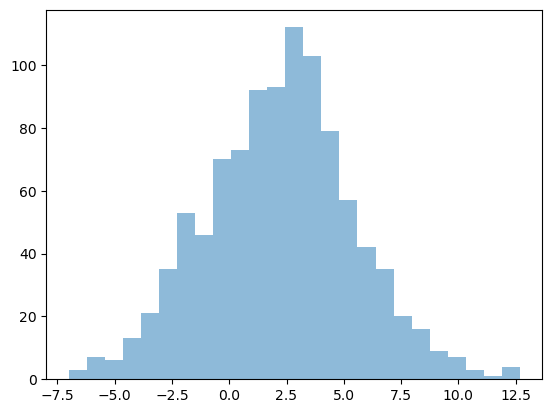

In [12]:
fig, ax = plt.subplots()
ax.hist(s_n, bins=25, alpha=0.5)
plt.show()

Actually what we want is $S_n = \exp(s_n)$, so let's look at the distribution.

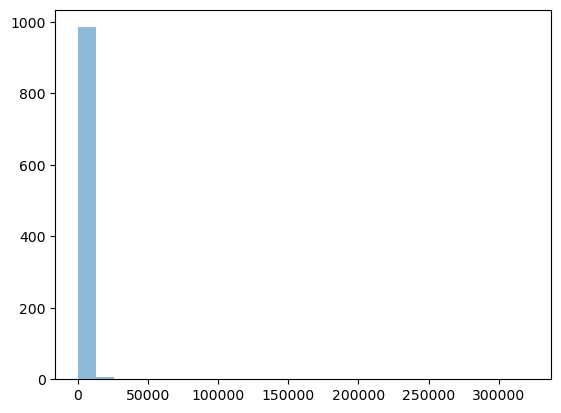

In [13]:
S_n = np.exp(s_n)
fig, ax = plt.subplots()
ax.hist(S_n, bins=25, alpha=0.5)
plt.show()

We can see that it's heavy-tailed

* many small observations
* a few very large ones


### Computing the price of the option

Now we have observations of the share price, we can get an estimate of the option price via

$$
    \beta^n \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
$$

In [14]:
price = β**n * np.mean(np.maximum(S_n - K, 0))
price 

1550.4557436788666

Let's write a function to do this

In [15]:
def compute_call_price_py(β=β,
                           μ=μ,
                           S_0=S_0,
                           h_0=h_0,
                           K=K,
                           n=n,
                           ρ=ρ,
                           ν=ν,
                           M=1_000_000,
                           seed=1234):
    np.random.seed(seed)

    s_0 = np.log(S_0)
    s_n = np.empty(M)

    for m in range(M):
        s, h = s_0, h_0
        for t in range(n):
            U, V = np.random.randn(2)
            s = s + μ + np.exp(h) * U
            h = ρ * h + ν * V
        s_n[m] = s

    S_n = np.exp(s_n)

    expectation = np.mean(np.maximum(S_n - K, 0))

    return β**n * expectation

Let's try computing the price

In [16]:
%time compute_call_price_py(seed=1)

CPU times: user 19.7 s, sys: 184 ms, total: 19.9 s
Wall time: 19.7 s


1273.8565699585529

The runtime is very long, even with moderate sample size $M$

Moreover, the sample size is still too small!

To see this, let's try again with a different seed

In [17]:
%time compute_call_price_py(seed=2)

CPU times: user 19.3 s, sys: 128 ms, total: 19.4 s
Wall time: 19.3 s


1434.1672128037624

Notice the big variation in the price --- the variance of our estimate is too high.

How can we make this faster?